In [1]:
# Check python version
!python -V

Python 3.10.9


In [1]:
# Required packages
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle

In [3]:
# Read data (.parquet format)
taxi01 = pl.read_parquet('./data/green_tripdata_2021-01.parquet')

In [4]:
# Check the different columns
taxi01.head()

VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
i64,datetime[ns],datetime[ns],str,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,null,f64,f64,f64,f64,f64
2,2021-01-01 00:15:56,2021-01-01 00:19:52,"""N""",1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.0,0.0,null,0.3,6.8,2.0,1.0,0.0
2,2021-01-01 00:25:59,2021-01-01 00:34:44,"""N""",1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,null,0.3,16.86,1.0,1.0,2.75
2,2021-01-01 00:45:57,2021-01-01 00:51:55,"""N""",1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.0,0.0,null,0.3,8.3,1.0,1.0,0.0
2,2020-12-31 23:57:51,2021-01-01 00:04:56,"""N""",1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.0,0.0,null,0.3,9.3,2.0,1.0,0.0
2,2021-01-01 00:16:36,2021-01-01 00:16:40,"""N""",2.0,265,265,3.0,0.0,-52.0,0.0,-0.5,0.0,0.0,null,-0.3,-52.8,3.0,1.0,0.0


In [5]:
# Select only "Dispatch" (trips arranged by phone)
# taxi01 = taxi01.filter(pl.any(pl.col('trip_type') == 2))

In [6]:
# Add the duration of the ride as a new column
taxi01 = taxi01.with_columns(
                (pl.col('lpep_dropoff_datetime') - 
                 pl.col('lpep_pickup_datetime')).alias('duration')
)

In [7]:
# Convert 'duration' column to minutes
taxi01 = taxi01.with_columns([
           (pl.col('duration').dt.seconds() / 60)
])

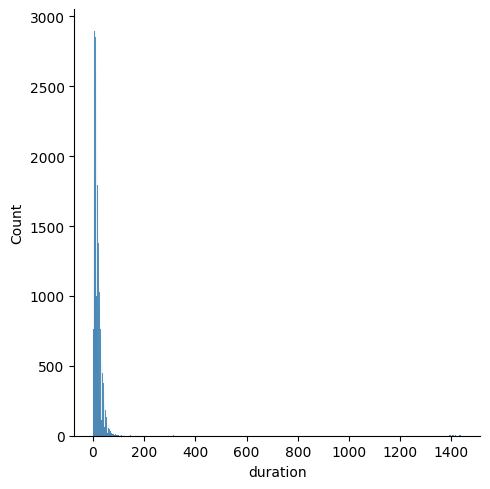

In [8]:
# Plot the distribution of the 'duration' column
sns.displot(taxi01.to_pandas(), x='duration')

In [9]:
# We observe that most of the trips are of a short duration.
# We can further verify this by looking at percentiles 
taxi01.select(pl.col('duration')).describe(percentiles=[0.95,0.98,0.99])

describe,duration
str,f64
"""count""",76518.0
"""null_count""",0.0
"""mean""",19.927896
"""std""",59.338594
"""min""",0.0
"""max""",1439.6
"""median""",13.883333
"""95%""",44.0
"""98%""",56.0


In [10]:
# Certainly, around 98% of the trips are below 1h. Therefore, 
# we focus on those trips. Additionally, we remove trips < 1min
taxi01 = taxi01.filter(
    pl.any((pl.col('duration') >= 1) & (pl.col('duration') <= 60))
)

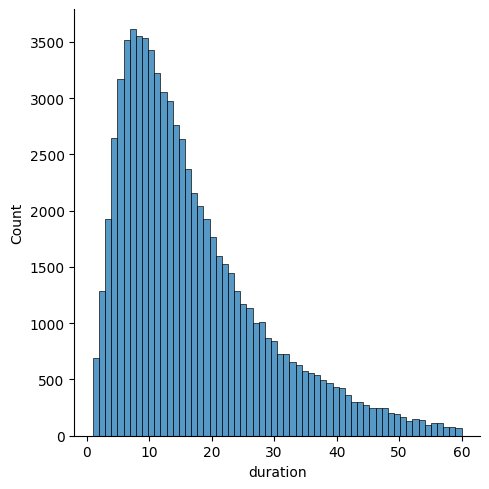

In [11]:
# Plot the filtered distribution 
sns.displot(taxi01.to_pandas(), x='duration',bins=60)

In [12]:
# Let's select the following features for the model
#     - Taxi Zone in which the taximeter was engaged
#     - Taxi Zone in which the taximeter was disengaged
#     - Trip distance
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
# The categorical needs to be in string format to do OneShotEncoding
taxi01 = taxi01.with_columns(pl.col(categorical).cast(pl.Utf8))
# We extract the features
features = taxi01.select(pl.col(categorical+numerical))
features.head()

PULocationID,DOLocationID,trip_distance
str,str,f64
"""43""","""151""",1.01
"""166""","""239""",2.53
"""41""","""42""",1.12
"""168""","""75""",1.99
"""75""","""75""",0.45


In [13]:
# To do OneShotEncoding we use scikit-learn's DictVectorizer
# 1) Convert DataFrame to Dict
train_dicts = features.to_dicts() # Each DataFrame row is a Dict
# 2) Use DictVectorizer (doesn't do OneHotEncoding on the numerical)
X_train = DictVectorizer().fit_transform(train_dicts)
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [14]:
target = 'duration'
# Extract target to numpy to be used by scikit-learn
y_train = taxi01.select(pl.col('duration')).to_numpy()
y_train

array([[ 3.93333333],
       [ 8.75      ],
       [ 5.96666667],
       ...,
       [11.        ],
       [27.        ],
       [10.        ]])

In [15]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
# (validation set will be added later)

LinearRegression()

In [16]:
# We calculate the prediction on the train set
y_pred = linreg.predict(X_train)

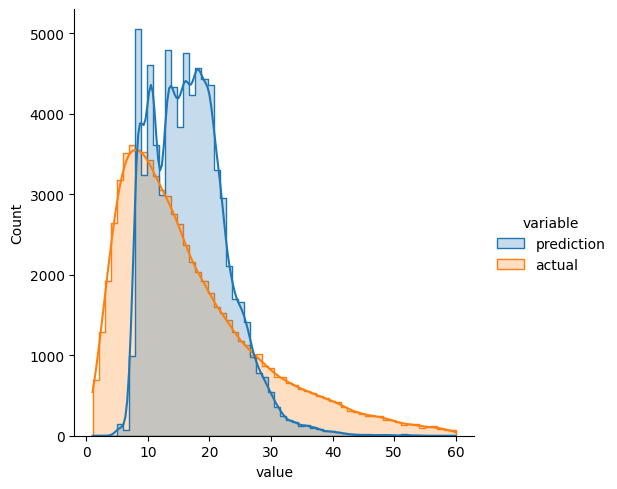

In [28]:
# We compare the predicition with the true values (target)
df = pd.DataFrame({"prediction": y_pred.flatten(), "actual": y_train.flatten()})
df = pd.melt(df, value_vars=['prediction', 'actual'])
sns.displot(df,x='value', hue='variable', kde=True, bins=60, element="step")

In [31]:
# There is a large difference between the prediction and the true value
# If we calculate the RMSE:
mean_squared_error(y_train,y_pred,squared=False)
# Our model is wrong by almost 10min by average

9.827368941909368

In [2]:
# We can reorganize all the previous prepocessing code into one function

def read_dataframe(filename):
    df = pl.read_parquet(filename)
    df = df.with_columns(
                (pl.col('lpep_dropoff_datetime') - 
                 pl.col('lpep_pickup_datetime')).alias('duration'))
    df = df.with_columns([
           (pl.col('duration').dt.seconds() / 60)])
    df = df.filter(
            pl.any((pl.col('duration') >= 1) &
                   (pl.col('duration') <= 60)))
    categorical = ['PULocationID','DOLocationID']
    df = df.with_columns(pl.col(categorical).cast(pl.Utf8))
    return df

# and for training as well

def train(df_train, df_val, cat, num, target):
    
    feat_train = df_train.select(pl.col(cat+num))
    feat_val   = df_val.select(pl.col(cat+num))
    train_dicts = feat_train.to_dicts() 
    val_dicts   = feat_val.to_dicts() 
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train.select(pl.col(target)).to_numpy()
    X_val = dv.transform(val_dicts)
    y_val = df_val.select(pl.col(target)).to_numpy()
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    
    y_pred_train = linreg.predict(X_train)
    y_pred_val   = linreg.predict(X_val)
    
    rmse_train = mean_squared_error(y_train,y_pred_train,squared=False)
    rmse_val   = mean_squared_error(y_val,y_pred_val,squared=False)
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Validation: {rmse_val}')
    
    df_t = pd.DataFrame({"prediction": y_pred_train.flatten(),
                         "actual": y_train.flatten()})
    df_v = pd.DataFrame({"prediction": y_pred_val.flatten(),
                         "actual": y_val.flatten()})
    df_t = pd.melt(df_t, value_vars=['prediction', 'actual'])
    df_v = pd.melt(df_v, value_vars=['prediction', 'actual'])
    sns.displot(df_t,x='value', hue='variable', 
                kde=True, bins=60, element="step").set(title='Train')
    sns.displot(df_v,x='value', hue='variable', 
                kde=True, bins=60, element="step").set(title='Validation')
    plt.show()
    return linreg, dv

In [12]:
# We can now load train data (again)
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
# and validation data (February)
df_val   = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
# Compare their sizes
len(df_train), len(df_val)

(73908, 61921)

In [14]:
target = 'duration'
# categorical = ['PULocationID','DOLocationID']
# Instead we are doing some feature engineering and combine them 
# Somehow it can be understood as an average of the taxi areas 
# where passengers take and leave the taxi
df_train = df_train.with_columns(pl.concat_str(
                                  ['PULocationID','DOLocationID'],
                                     separator="_").alias('PU_DO'))
df_val = df_val.with_columns(pl.concat_str(
                                  ['PULocationID','DOLocationID'],
                                     separator="_").alias('PU_DO'))
categorical = ['PU_DO']
numerical = ['trip_distance']

RMSE Train: 5.699564118198949
RMSE Validation: 7.758715208269472


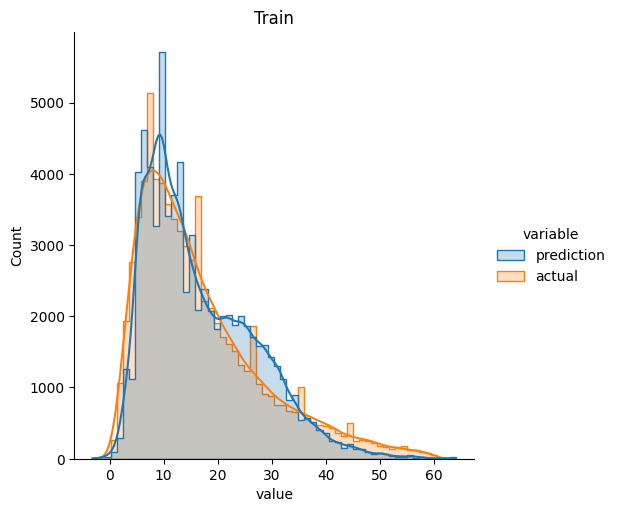

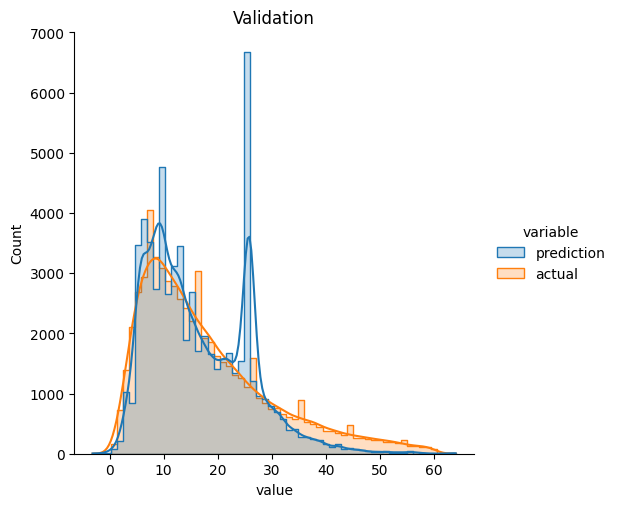

In [101]:
linreg, dv = train(df_train, df_val, categorical, numerical, target)

In [102]:
# We can now save the model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, linreg), f_out)

## Course overview

Reference : __[github.com/ziritrion](https://github.com/ziritrion/mlopszoomcamp/blob/main/notes/1_intro.md)__

When data scientists experiment with Jupyter Notebooks for creating models, they often don't follow best practices and are often unstructured due to the nature of experimentation: cells are re-run with slightly different values and previous results may be lost, or the cell execution order may be inconsistent.

- **Module 2** covers experiment tracking by using tools such as MLflow. We will create experiment trackers (such as the history of cells that we've rerun multiple times) and model registries (for storing the models we've created during the experiments), instead of relying on our memory or janky setups such as external spreadsheets or convoluted naming schemes for our files.

- **Module 3** covers orchestration and ML pipelines: by using Prefect  we can break down our notebooks into separate identifyable steps and connect them in order to create a ML pipeline which we can parametrize with the data and models we want and easily execute.

- **Module 4** covers serving the models: we will learn how to deploy models in different ways using Flask.

- **Module 5** covers model monitoring: we will see how to check whether our model is performing fine or not and how to generate alers to warn us of performance drops and failures, and even automate retraining and redeploying models without human input. We will use Evidently, Prefect, MongoDB among others tools.

- **Module 6** covers best practices, such as unit testing, linting, CI/CD, ..., etc.

## MLOps Maturity Model

References : __[github.com/balapriyac](https://github.com/balapriyac/DTC-MLOps-Zoomcamp/blob/main/week1/MLOps-maturity-levels.md)__, __[MLOps Maturity model (Microsoft)](https://learn.microsoft.com/en-us/azure/architecture/example-scenario/mlops/mlops-maturity-model)__

| Level  |	Description  |  Overview  |  When Should You Use?  |
|  :-:   |      :-      |     :-    |           :-          |
| 0  | No Automation | - All code in Jupyter Notebook <br> - No pipeline, experiment tracking,<br> and metadata | - Academic projects <br> - Proof of Concept is the end <br> goal, not production-ready models  |
| 1  | Yes! DevOps, No MLOps | - Best engineering practices followed <br> - Automated releases <br> - Unit & Integration Tests <br> - CI/CD pipelines <br> - No experiment tracking and reproducibility <br> - Good from engineering standpoint, <br> models are not ML-aware yet! | - Moving from proof of concept <br> to production <br> - When you need some automation  |
| 2  |	Automated Training  | - Training pipelines <br> - Experiment tracking <br> - Model registry (track of currently <br> deployed models) <br> - Data scientists work in tandem <br> with the engineering team <br> - Low friction deployment   | - When you have increasing number of use cases <br> - Three or more use cases, you <br> should definitely consider automating!   |
| 3  |	Automated Deployment  |  - Model deployment simplified! <br> - Prep data >> Train model >> Deploy model <br> - A/B testing <br> - Model X: v1, v2 >> v2 is deployed;<br>  how to ensure v2 performs better? <br> - Model monitoring   |  - Multiple use cases <br> - More mature + important use cases  |
| 4  |	Full MLOps Automation  |  - Automated training <br> - Automated retraining <br> - Automated deployment  | - Check if level 2, 3 won't suffice <br> - Should model retraining and <br> deployment be automated as well? <br> - Super important to take a pragmatic <br> decision! Do you really need level 4?   |

## Homework
The goal of this homework is to train a simple model for predicting the duration of a ride

#### Q1. Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records" for January and February 2022.

Read the data for January. How many columns are there?

In [24]:
# This database is much larger than 2021 (~2.5M rows)
yellow_train = pl.read_parquet('./data/yellow_tripdata_2022-01.parquet')
# Number of columns 
len(yellow_train.columns)

19

#### Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [25]:
yellow_train = yellow_train.with_columns(
                (pl.col('tpep_dropoff_datetime') - 
                 pl.col('tpep_pickup_datetime')).alias('duration'))
yellow_train = yellow_train.with_columns([
           (pl.col('duration').dt.seconds() / 60)])
# Standard deviation of 'duration' column
yellow_train.select(pl.std('duration'))

duration
f64
46.445305


#### Q3. Dropping outliers
Next, we need to check the distribution of the 'duration' variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [29]:
nrows_prev = yellow_train.shape[0]
yellow_train = yellow_train.filter(pl.any((pl.col('duration') >= 1) &
                                          (pl.col('duration') <= 60)))
nrows = yellow_train.shape[0]
fraction_left = nrows / nrows_prev
fraction_left

0.9827547930522406

#### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it
    
What's the dimensionality of this matrix (number of columns)?

In [31]:
categorical = ['PULocationID','DOLocationID']
yellow_train = yellow_train.with_columns(
                    pl.col(categorical).cast(pl.Utf8))
features = yellow_train.select(pl.col(categorical))
yellow_train_dicts = features.to_dicts()
dv = DictVectorizer()
X_train = dv.fit_transform(yellow_train_dicts)
X_train

<2421440x515 sparse matrix of type '<class 'numpy.float64'>'
	with 4842880 stored elements in Compressed Sparse Row format>

#### Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [32]:
y_train = yellow_train.select(pl.col('duration')).to_numpy()

linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_train)

mean_squared_error(y_train,y_pred,squared=False)

6.986190841034851

#### Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

In [33]:
# Updated functions for the 2022 data

def read_dataframe(filename):
    df = pl.read_parquet(filename)
    df = df.with_columns(
                (pl.col('tpep_dropoff_datetime') - 
                 pl.col('tpep_pickup_datetime')).alias('duration'))
    df = df.with_columns([
           (pl.col('duration').dt.seconds() / 60)])
    df = df.filter(
            pl.any((pl.col('duration') >= 1) &
                   (pl.col('duration') <= 60)))
    categorical = ['PULocationID','DOLocationID']
    df = df.with_columns(pl.col(categorical).cast(pl.Utf8))
    return df

def train(df_train, df_val, cat, target):
    
    feat_train = df_train.select(pl.col(cat))
    feat_val   = df_val.select(pl.col(cat))
    train_dicts = feat_train.to_dicts() 
    val_dicts   = feat_val.to_dicts() 
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train.select(pl.col(target)).to_numpy()
    X_val = dv.transform(val_dicts)
    y_val = df_val.select(pl.col(target)).to_numpy()
    
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)
    
    y_pred_train = linreg.predict(X_train)
    y_pred_val   = linreg.predict(X_val)
    
    rmse_train = mean_squared_error(y_train,y_pred_train,squared=False)
    rmse_val   = mean_squared_error(y_val,y_pred_val,squared=False)
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Validation: {rmse_val}')

    return None

In [34]:
yellow_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
yellow_val   = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

target = 'duration'
categorical = ['PULocationID','DOLocationID']

train(yellow_train, yellow_val, categorical, target)

RMSE Train: 6.986190841034851
RMSE Validation: 7.786408695263233
